In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sncosmo
import glob
import ipywidgets as widgets
from scipy.interpolate import interp1d
import math
import extinction

In [2]:
train=["1990O","1990af","1992P","1992ae","1992al","1992bc","1992bg","1992bl","1992bo","1992bp","1992br","1993H","1993O","1993ag","1994M","1995ac","1996C","1996bl","1997E","1997Y","1997bq","1998V","1998ab","1998bp","1998de","1998es","1999aa","1999ac","1999da","1999gp","2000ca","2000cf","2000dk","2000fa","2001V","2001cz","2002er"]

## Extinction

In [3]:
lambda_eff={"U":[3600.],"B":[4500.],"V":[5500.],"R":[6600.],"I":[8000.]}
RV=3.1
def mw_ext_cor(mwebv):
    ext={"U":extinction.ccm89(np.array(lambda_eff["U"]),mwebv*RV,RV)[0],
    "B":extinction.ccm89(np.array(lambda_eff["B"]),mwebv*RV,RV)[0],
    "V":extinction.ccm89(np.array(lambda_eff["V"]),mwebv*RV,RV)[0],
    "R":extinction.ccm89(np.array(lambda_eff["R"]),mwebv*RV,RV)[0],
    "I":extinction.ccm89(np.array(lambda_eff["I"]),mwebv*RV,RV)[0]}
    return ext

## Original model vectors

In [4]:
zeta=pd.read_csv("original_model_templates/zeta.dat",sep='\s+',comment='#',header=None)
zeta.columns=["#phase", "zeta_U", "zeta_B", "zeta_V", "zeta_R", "zeta_I"]

zeta=zeta[(zeta["#phase"]>-11.) & (zeta["#phase"]<51.)]

In [5]:
alphabeta=pd.read_csv("original_model_templates/alphabeta.dat",sep='\s+',comment='#',header=None)

alpha={}
beta={}

for i in alphabeta[0]:
    alpha[i]=alphabeta[alphabeta[0]==i][1].values[0]
    beta[i]=alphabeta[alphabeta[0]==i][2].values[0]

In [6]:
vec_U=pd.read_csv('./original_model_templates/vectors_U.dat',sep='\s+') # M^0_U, P_U, Q_U
vec_B=pd.read_csv('./original_model_templates/vectors_B.dat',sep='\s+') # M^0_B, P_B, Q_B
vec_V=pd.read_csv('./original_model_templates/vectors_V.dat',sep='\s+') # M^0_V, P_V, Q_V
vec_R=pd.read_csv('./original_model_templates/vectors_R.dat',sep='\s+') # M^0_R, P_R, Q_R
vec_I=pd.read_csv('./original_model_templates/vectors_I.dat',sep='\s+') # M^0_I, P_I, Q_I

In [7]:
vec_U=vec_U[(vec_U["#phase"]>-11.) & (vec_U["#phase"]<51.)] 
vec_B=vec_B[(vec_B["#phase"]>-11.) & (vec_B["#phase"]<51.)] 
vec_V=vec_V[(vec_V["#phase"]>-11.) & (vec_V["#phase"]<51.)] 
vec_R=vec_R[(vec_R["#phase"]>-11.) & (vec_R["#phase"]<51.)] 
vec_I=vec_I[(vec_I["#phase"]>-11.) & (vec_I["#phase"]<51.)] 

In [8]:
vec={"U":vec_U,"B":vec_B,"V":vec_V,"R":vec_R,"I":vec_I}

## Reading original parameters

In [9]:
data=pd.read_csv("data.txt",sep="\s+",comment="#")

In [10]:
delta={}
mu0={}
incdelta={}
A0_V={}
R_V={}
for SN in train:
    delta[SN]=data[data["SNIa"]==SN]["Delta"].values[0]
    incdelta[SN]=data[data["SNIa"]==SN]["+/-.2"].values[0]
    mu0[SN]=data[data["SNIa"]==SN]["mu0+5logh65"].values[0]
    A0_V[SN]=data[data["SNIa"]==SN]["A^0_V"].values[0]
    R_V[SN]=data[data["SNIa"]==SN]["R_V"].values[0]

## Reading LCs

In [11]:
paths=glob.glob("/home/cassia/SNANA/snroot/lcmerge/LOWZ_JRK07/*.DAT")

path="/home/cassia/SNANA/snroot/lcmerge/LOWZ_JRK07/LOWZ_JRK07_"

name=list()
for i in range(len(paths)):
    name.append(paths[i].split('_')[3].split('.')[0])

In [12]:
data_U={}
data_B={}
data_V={}
data_R={}
data_I={}

In [13]:
d={"U":data_U,"B":data_B,"V":data_V,"R":data_R,"I":data_I}

In [14]:
for SN in train:
    meta, lc_data=sncosmo.read_snana_ascii(path+SN+'.DAT',default_tablename="OBS")
    lc_data=lc_data["OBS"].to_pandas()    
    red=str(meta["REDSHIFT_FINAL"])
    peak_mjd=meta["SEARCH_PEAKMJD"]
    mwebv=meta["MWEBV"]
    lc_data["(MJD-PEAK)/(1+z)"]=(lc_data["MJD"]-peak_mjd)/(1+float(red))
    lc_data=lc_data[(lc_data["(MJD-PEAK)/(1+z)"]>=-10) & (lc_data["(MJD-PEAK)/(1+z)"]<=50)] # cut in Trest
    
    ext=mw_ext_cor(mwebv)
    for f in lc_data["FLT"].unique():
        df=lc_data[lc_data["FLT"]==f].reset_index(drop=True)
        df=df.drop("MAG", axis=1)
        new_mag=-2.5*np.log10(df["FLUXCAL"].values*10**(0.4*ext[f]))+27.5
        df["MAG"]=new_mag
        d[f][SN]=df

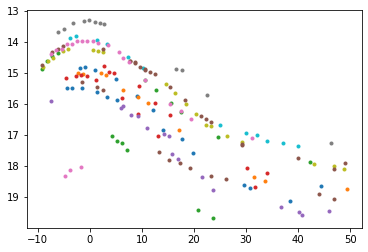

In [15]:
for sn in d["U"].keys():
    plt.plot(d["U"][sn]["(MJD-PEAK)/(1+z)"],d["U"][sn]["MAG"],'.')
plt.gca().invert_yaxis()

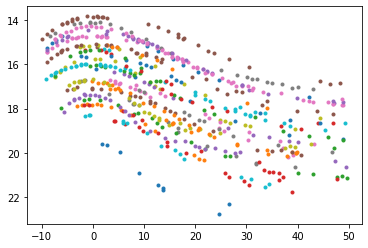

In [16]:
for sn in d["B"].keys():
    plt.plot(d["B"][sn]["(MJD-PEAK)/(1+z)"],d["B"][sn]["MAG"],'.')
plt.gca().invert_yaxis()

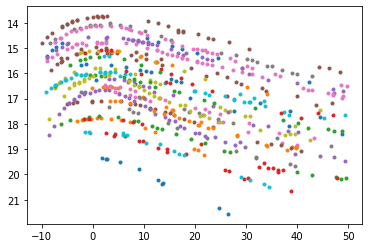

In [17]:
for sn in d["V"].keys():
    plt.plot(d["V"][sn]["(MJD-PEAK)/(1+z)"],d["V"][sn]["MAG"],'.')
plt.gca().invert_yaxis()

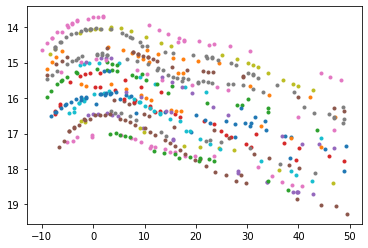

In [18]:
for sn in d["R"].keys():
    plt.plot(d["R"][sn]["(MJD-PEAK)/(1+z)"],d["R"][sn]["MAG"],'.')
plt.gca().invert_yaxis()

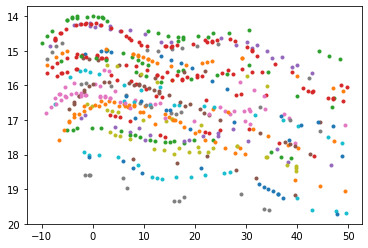

In [19]:
for sn in d["I"].keys():
    plt.plot(d["I"][sn]["(MJD-PEAK)/(1+z)"],d["I"][sn]["MAG"],'.')
plt.gca().invert_yaxis()

In [20]:
M0_U=interp1d(vec["U"]["#phase"],vec["U"]["M^0_U"])
zeta_U=interp1d(zeta["#phase"],zeta["zeta_U"])
M0_B=interp1d(vec["B"]["#phase"],vec["B"]["M^0_B"])
zeta_B=interp1d(zeta["#phase"],zeta["zeta_B"])
M0_V=interp1d(vec["V"]["#phase"],vec["V"]["M^0_V"])
zeta_V=interp1d(zeta["#phase"],zeta["zeta_V"])
M0_R=interp1d(vec["R"]["#phase"],vec["R"]["M^0_R"])
zeta_R=interp1d(zeta["#phase"],zeta["zeta_R"])
M0_I=interp1d(vec["I"]["#phase"],vec["I"]["M^0_I"])
zeta_I=interp1d(zeta["#phase"],zeta["zeta_I"])

In [21]:
data_U_reg={}
data_B_reg={}
data_V_reg={}
data_R_reg={}
data_I_reg={}

In [22]:
d_reg={"U":data_U_reg,"B":data_B_reg,"V":data_V_reg,"R":data_R_reg,"I":data_I_reg}

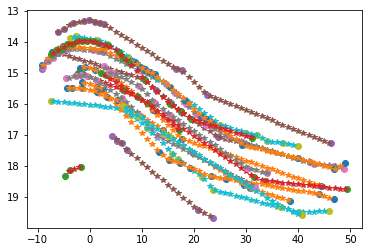

In [23]:
for sn in d["U"].keys():
    phase=d["U"][sn]["(MJD-PEAK)/(1+z)"]
    mag=d["U"][sn]["MAG"]
    mag_int=interp1d(phase,mag,kind="slinear")
    new_ph=np.arange(math.ceil(min(phase)),math.floor(max(phase))+1,1.)
    
    termo_linear=delta[sn]*(mag_int(new_ph)-M0_U(new_ph)-mu0[sn]-zeta_U(new_ph)*(alpha["U"]+beta["U"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    termo_quadratico=delta[sn]**2*(mag_int(new_ph)-M0_U(new_ph)-mu0[sn]-zeta_U(new_ph)*(alpha["U"]+beta["U"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    
    d_reg["U"][sn]=[new_ph,termo_linear,termo_quadratico]
        
    plt.plot(phase,mag,'o')
    plt.plot(new_ph,mag_int(new_ph),'*')
plt.gca().invert_yaxis()

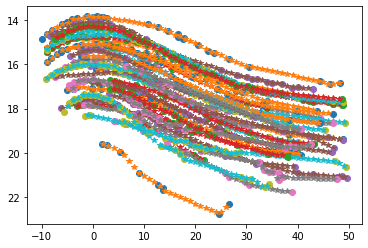

In [24]:
for sn in d["B"].keys():
    phase=d["B"][sn]["(MJD-PEAK)/(1+z)"]
    mag=d["B"][sn]["MAG"]
    mag_int=interp1d(phase,mag,kind="slinear")
    new_ph=np.arange(math.ceil(min(phase)),math.floor(max(phase))+1,1.)
    
    termo_linear=delta[sn]*(mag_int(new_ph)-M0_B(new_ph)-mu0[sn]-zeta_B(new_ph)*(alpha["B"]+beta["B"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    termo_quadratico=delta[sn]**2*(mag_int(new_ph)-M0_B(new_ph)-mu0[sn]-zeta_B(new_ph)*(alpha["B"]+beta["B"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    
    d_reg["B"][sn]=[new_ph,termo_linear,termo_quadratico]
        
    plt.plot(phase,mag,'o')
    plt.plot(new_ph,mag_int(new_ph),'*')
plt.gca().invert_yaxis()

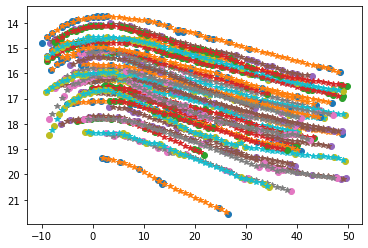

In [25]:
for sn in d["V"].keys():
    phase=d["V"][sn]["(MJD-PEAK)/(1+z)"]
    mag=d["V"][sn]["MAG"]
    mag_int=interp1d(phase,mag,kind="slinear")
    new_ph=np.arange(math.ceil(min(phase)),math.floor(max(phase))+1,1.)
    
    termo_linear=delta[sn]*(mag_int(new_ph)-M0_V(new_ph)-mu0[sn]-zeta_V(new_ph)*(alpha["V"]+beta["V"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    termo_quadratico=delta[sn]**2*(mag_int(new_ph)-M0_V(new_ph)-mu0[sn]-zeta_V(new_ph)*(alpha["V"]+beta["V"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    
    d_reg["V"][sn]=[new_ph,termo_linear,termo_quadratico]
        
    plt.plot(phase,mag,'o')
    plt.plot(new_ph,mag_int(new_ph),'*')
plt.gca().invert_yaxis()

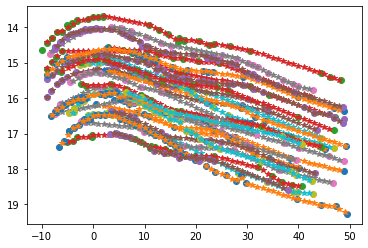

In [26]:
for sn in d["R"].keys():
    phase=d["R"][sn]["(MJD-PEAK)/(1+z)"]
    mag=d["R"][sn]["MAG"]
    mag_int=interp1d(phase,mag,kind="slinear")
    new_ph=np.arange(math.ceil(min(phase)),math.floor(max(phase))+1,1.)
    
    termo_linear=delta[sn]*(mag_int(new_ph)-M0_R(new_ph)-mu0[sn]-zeta_R(new_ph)*(alpha["R"]+beta["R"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    termo_quadratico=delta[sn]**2*(mag_int(new_ph)-M0_R(new_ph)-mu0[sn]-zeta_R(new_ph)*(alpha["R"]+beta["R"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    
    d_reg["R"][sn]=[new_ph,termo_linear,termo_quadratico]
        
    plt.plot(phase,mag,'o')
    plt.plot(new_ph,mag_int(new_ph),'*')
plt.gca().invert_yaxis()

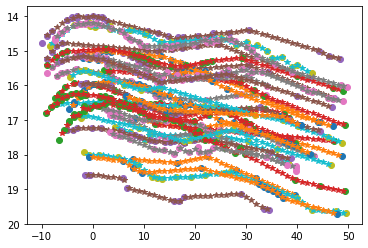

In [27]:
for sn in d["I"].keys():
    phase=d["I"][sn]["(MJD-PEAK)/(1+z)"]
    mag=d["I"][sn]["MAG"]
    mag_int=interp1d(phase,mag,kind="slinear")
    new_ph=np.arange(math.ceil(min(phase)),math.floor(max(phase))+1,1.)
    
    termo_linear=delta[sn]*(mag_int(new_ph)-M0_I(new_ph)-mu0[sn]-zeta_I(new_ph)*(alpha["I"]+beta["I"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    termo_quadratico=delta[sn]**2*(mag_int(new_ph)-M0_I(new_ph)-mu0[sn]-zeta_I(new_ph)*(alpha["I"]+beta["I"]/R_V[sn])*A0_V[sn])/incdelta[sn]
    
    d_reg["I"][sn]=[new_ph,termo_linear,termo_quadratico]
        
    plt.plot(phase,mag,'o')
    plt.plot(new_ph,mag_int(new_ph),'*')
plt.gca().invert_yaxis()

In [28]:
phase_array=np.arange(-10,51,1)

In [29]:
def power_delta(p,snlist):
    s=0
    for SN in snlist:
        s+=delta[SN]**p/incdelta[SN]
    return s

In [30]:
P_U=[]
Q_U=[]
days_U=[]

In [31]:
for p in phase_array:
    l=0
    q=0
    snlist=[]
    for sn in d_reg["U"].keys():
        if p in d_reg["U"][sn][0]:
            snlist.append(sn)
            ind=np.where(d_reg["U"][sn][0]==p)[0]
            l+=d_reg["U"][sn][1][ind]
            q+=d_reg["U"][sn][2][ind]
    if l>0.:
        days_U.append(p)
        P_U.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
        Q_U.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))
    else:
        pass

/tmp/ipykernel_7286/4205108585.py:13: RuntimeWarning: invalid value encountered in true_divide
  P_U.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
/tmp/ipykernel_7286/4205108585.py:14: RuntimeWarning: divide by zero encountered in true_divide
  Q_U.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))


In [32]:
P_B=[]
Q_B=[]
days_B=[]

In [33]:
for p in phase_array:
    l=0
    q=0
    snlist=[]
    for sn in d_reg["B"].keys():
        if p in d_reg["B"][sn][0]:
            snlist.append(sn)
            ind=np.where(d_reg["B"][sn][0]==p)[0]
            l+=d_reg["B"][sn][1][ind]
            q+=d_reg["B"][sn][2][ind]
    if l>0.:
        days_B.append(p)
        P_B.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
        Q_B.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))
    else:
        pass

In [34]:
P_V=[]
Q_V=[]
days_V=[]

In [35]:
for p in phase_array:
    l=0
    q=0
    snlist=[]
    for sn in d_reg["V"].keys():
        if p in d_reg["V"][sn][0]:
            snlist.append(sn)
            ind=np.where(d_reg["V"][sn][0]==p)[0]
            l+=d_reg["V"][sn][1][ind]
            q+=d_reg["V"][sn][2][ind]
    if l>0.:
        days_V.append(p)
        P_V.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
        Q_V.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))
    else:
        pass

In [36]:
P_R=[]
Q_R=[]
days_R=[]

In [37]:
for p in phase_array:
    l=0
    q=0
    snlist=[]
    for sn in d_reg["R"].keys():
        if p in d_reg["R"][sn][0]:
            snlist.append(sn)
            ind=np.where(d_reg["R"][sn][0]==p)[0]
            l+=d_reg["R"][sn][1][ind]
            q+=d_reg["R"][sn][2][ind]
    if l>0.:
        days_R.append(p)
        P_R.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
        Q_R.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))
    else:
        pass

In [38]:
P_I=[]
Q_I=[]
days_I=[]

In [39]:
for p in phase_array:
    l=0
    q=0
    snlist=[]
    for sn in d_reg["I"].keys():
        if p in d_reg["I"][sn][0]:
            snlist.append(sn)
            ind=np.where(d_reg["I"][sn][0]==p)[0]
            l+=d_reg["I"][sn][1][ind]
            q+=d_reg["I"][sn][2][ind]
    if l>0.:
        days_I.append(p)
        P_I.append((q*power_delta(3,snlist)-l*power_delta(4,snlist))/(power_delta(3,snlist)*power_delta(3,snlist)-power_delta(4,snlist)*power_delta(2,snlist)))
        Q_I.append((q*power_delta(2,snlist)-l*power_delta(3,snlist))/(power_delta(4,snlist)*power_delta(2,snlist)-power_delta(3,snlist)*power_delta(3,snlist)))
    else:
        pass

In [45]:
P={"U":P_U[5:56],"B":P_B[4:58],"V":P_V[2:58],"R":P_R[2:58],"I":P_I[2:58]}

In [46]:
Q={"U":Q_U[5:56],"B":Q_B[4:58],"V":Q_V[2:58],"R":Q_R[2:58],"I":Q_I[2:58]}

In [47]:
days={"U":days_U[5:56],"B":days_B[4:58],"V":days_V[2:58],"R":days_R[2:58],"I":days_I[2:58]}

In [48]:
plt.rcParams['font.size'] = '16'

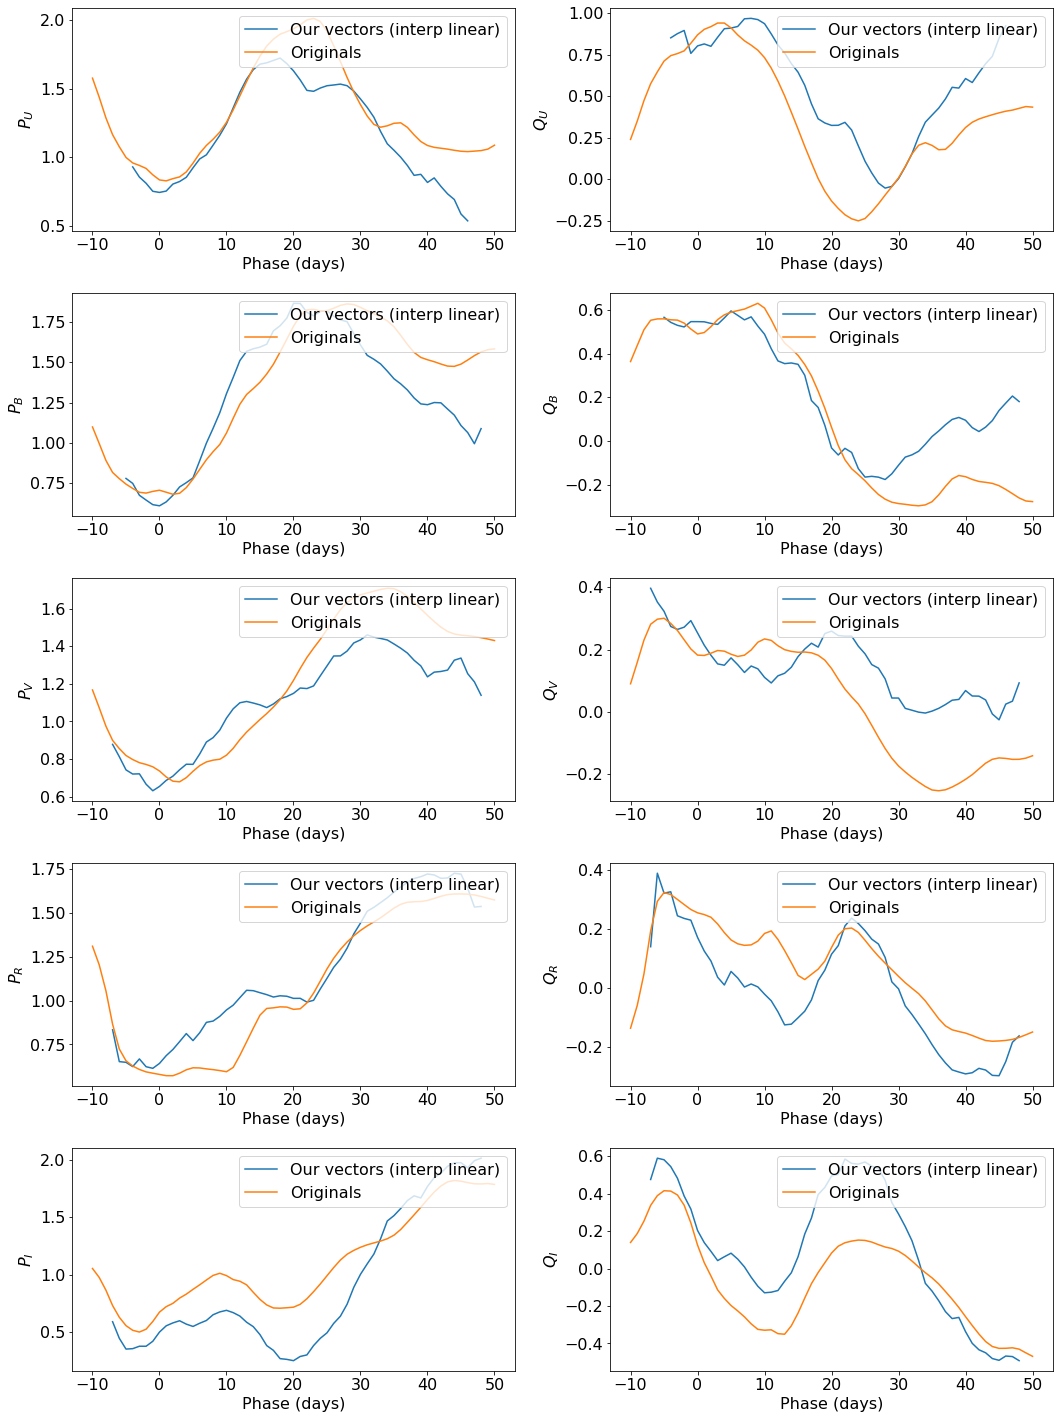

In [49]:
fig,axs= plt.subplots(5,2,figsize=(15,20))
i=0
for filt in ["U","B","V","R","I"]:
    
    axs[i,0].plot(days[filt],P[filt],label="Our vectors (interp linear)")
    axs[i,0].plot(np.arange(-10,51,1),vec[filt]["P_"+filt],label="Originals")
    axs[i,0].set_xlabel("Phase (days)")
    axs[i,0].set_ylabel(r"$P_"+filt+"$") # checar unidade
    axs[i,0].legend(loc=1)
    axs[i,1].plot(days[filt],Q[filt],label="Our vectors (interp linear)")
    axs[i,1].plot(np.arange(-10,51,1),vec[filt]["Q_"+filt],label="Originals")
    axs[i,1].set_xlabel("Phase (days)")
    axs[i,1].set_ylabel(r"$Q_"+filt+"$") # checar unidade
    axs[i,1].legend(loc=1)
    i+=1

fig.tight_layout()
plt.savefig("Comparison_model_vectors_interp_linear.png",facecolor='white',transparent=False);